<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/02_nice_with_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [52]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [53]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2), nn.ReLU()) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow, forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [54]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.20,
                                                   random_state=42)

X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

train_data = Data(X_train)


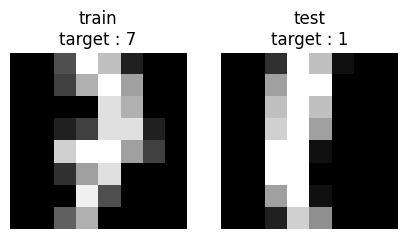

In [55]:
random_number = torch.randint(0,9,[1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [56]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=512, num_flows=10)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [57]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  93.36701329549153
Epoch :  100   -----------> Loss :  53.81754620869955
Epoch :  200   -----------> Loss :  15.692321936289469
Epoch :  300   -----------> Loss :  -21.349924087524414
Epoch :  400   -----------> Loss :  -55.73128000895182
Epoch :  500   -----------> Loss :  -83.23445002237956
Epoch :  600   -----------> Loss :  -103.2914644877116
Epoch :  700   -----------> Loss :  -114.43798446655273
Epoch :  800   -----------> Loss :  -131.84785970052084
Epoch :  900   -----------> Loss :  -140.86668904622397
Epoch :  1000   -----------> Loss :  -151.7693634033203


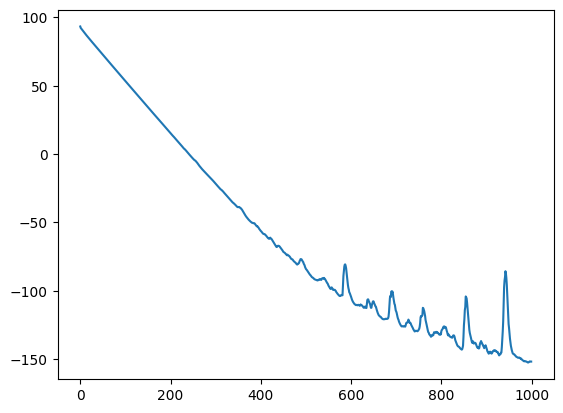

In [58]:
plt.plot(COST)

In [59]:
test = prior.sample((50,))
test

tensor([[ 0.9550,  0.5590,  0.6657,  ...,  0.0285, -2.7521, -0.1944],
        [-0.4060,  0.5201,  0.6664,  ..., -0.5098,  0.0973,  0.3155],
        [-0.1980, -0.3220,  0.2069,  ..., -0.8205,  1.4477, -1.8669],
        ...,
        [-0.2296, -0.3449, -1.5328,  ...,  0.0950,  0.4125,  1.3191],
        [-1.2682, -0.6472, -0.4417,  ..., -0.8760, -1.7654, -1.1943],
        [ 0.2769, -0.6415,  1.4514,  ..., -0.7337, -0.8166,  0.8739]])

In [60]:
sonuc = model.f_inv(test)
sonuc

tensor([[-3.2887e-03, -1.1235e-02,  4.3374e-01,  ...,  4.4705e-01,
         -8.2971e-02, -4.2591e-02],
        [ 3.7608e-03,  1.8235e-02,  1.6479e-01,  ...,  8.7291e-01,
          2.1549e-01,  1.8941e-02],
        [ 4.7283e-03, -1.0789e-01,  8.4626e-02,  ...,  7.5167e-01,
          1.7443e-01,  3.3098e-02],
        ...,
        [-2.9736e-04,  7.6229e-02,  1.9065e-01,  ..., -7.9979e-02,
          1.2437e-02, -5.6196e-05],
        [-1.4424e-03, -6.9019e-02, -4.0217e-02,  ...,  1.0102e+00,
          3.8452e-01, -2.9838e-02],
        [ 2.0047e-03,  5.0503e-02, -2.6089e-02,  ...,  6.7859e-01,
          5.3521e-02,  3.1869e-02]], grad_fn=<MulBackward0>)

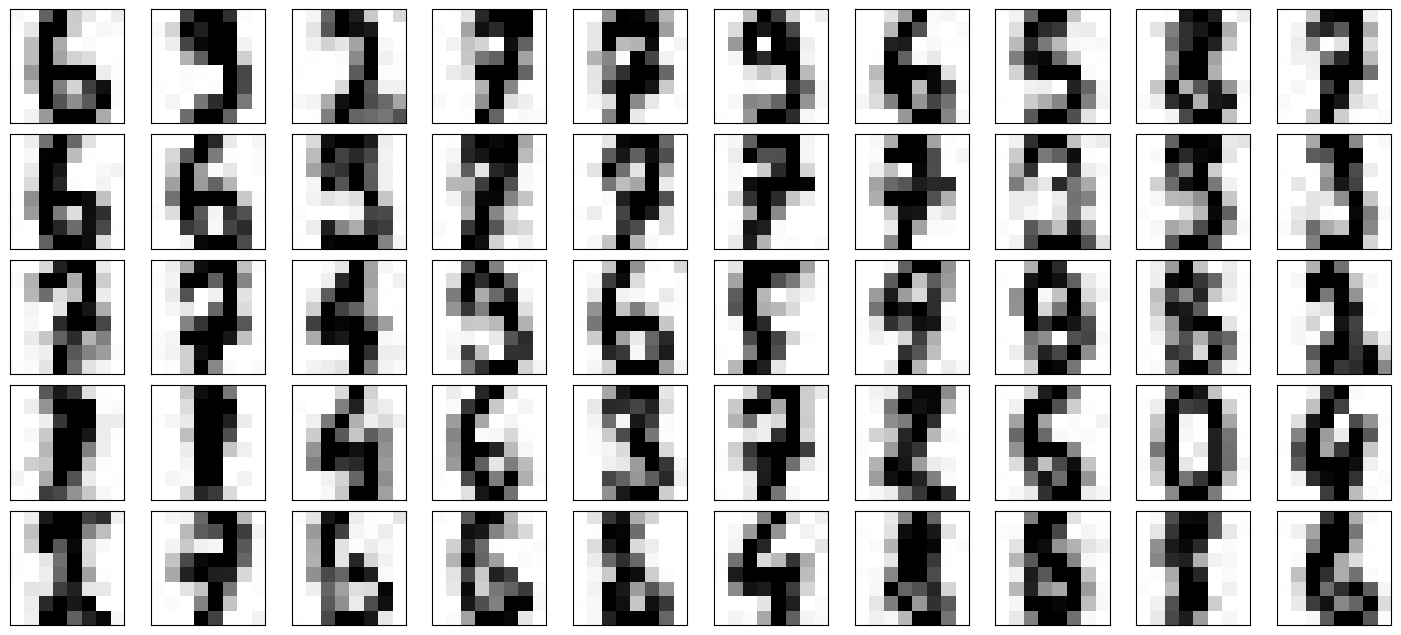

In [61]:
test = prior.sample((1797,))
sonuc = torch.nn.ReLU()(model.f_inv(test))

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
fig.show()


In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [63]:
forward, logdet_j = model.forward(torch.tensor(X_test))
backward = model.f_inv(forward)

In [64]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(360, 2)


In [65]:
projected_raw = pca.fit_transform(X_test)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(360, 2)


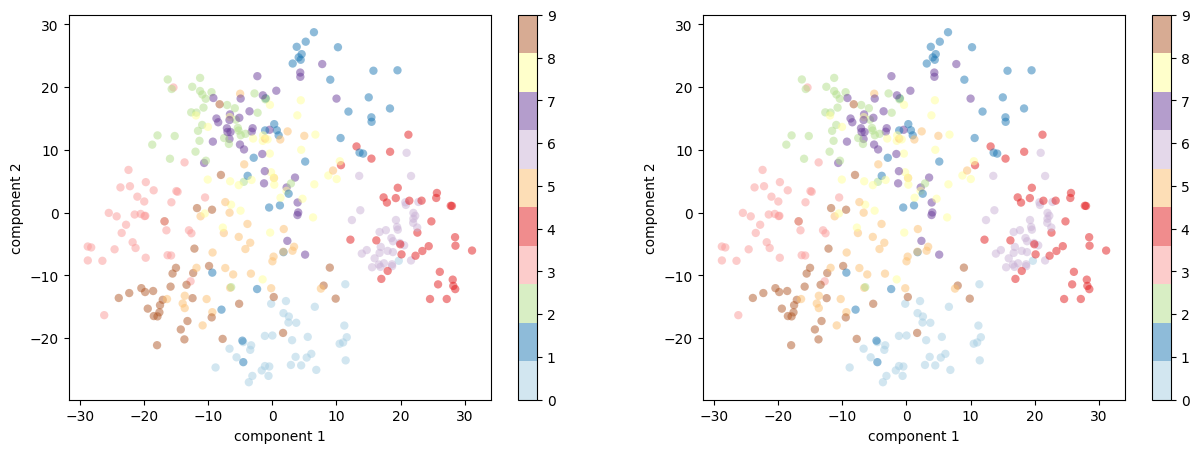

In [66]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()